In [1]:
#default_ext coco

# COCO
> Detail API

## Visualize


In [2]:
# export 
import os
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import mmcv
from fastcore.script import *
import shutil
from pycocotools.coco import COCO
import mmcv
import numpy as np

class VisualizeCoco:
    def __init__(self, gt, img_dir, pred=None):
        if isinstance(gt, str):
            from pycocotools.coco import COCO
            gt = COCO(gt)
        if isinstance(pred, str):
            pred = gt.loadRes(mmcv.load(pred))
            
        self.gt = gt
        self.pred = pred
        self.img_dir = img_dir
        self.img_ids = [_['id'] for _ in gt.imgs.values()]

    def visualize(self, img_id,  mode='gt'):        
        if mode=='pred':
            assert self.pred is not None
        gt = self.gt
        pred = self.pred
        CLASSES = [_['name'] for _ in self.gt.dataset['categories']]
        im = gt.imgs[img_id]
        source = pred if mode == 'pred' else gt
        anns = source.loadAnns(source.getAnnIds(im['id']))
        ann_ids = source.getAnnIds(im['id'])
#         if verbose:
#             print('Num of bboxes:', len(ann_ids))
        bb_preds  = source.loadAnns(ann_ids)

        det_bboxes = []
        lables = []
        for bb_pred in bb_preds:
            x1,y1,w,h = bb_pred['bbox']
            x2 = x1+w
            y2 = y1+h
            det_bboxes.append([x1,y1,x2,y2, bb_pred.get('score', 1)])
            lables.append(bb_pred['category_id'])

        det_bboxes = np.array(det_bboxes)
        lables = np.array(lables)
        img = mmcv.imread(self.img_dir+im['file_name'], channel_order='rgb')
        img = mmcv.visualization.imshow_det_bboxes(img, det_bboxes, lables, CLASSES, show=False)
        return img
    

In [4]:
coco = COCO('/data/tsd/annotations/train.json')

loading annotations into memory...
Done (t=4.20s)
creating index...
index created!


In [5]:
rm -r /data/tsd/cluster/

In [6]:
images = []
annotations = []
n = 20
out_dir = '/data/tsd/cluster'
mmcv.mkdir_or_exist(out_dir+'/images')
mmcv.mkdir_or_exist(out_dir+'/annotations')

In [9]:
import shutil

for cat_id in coco.getCatIds():
    imgs = coco.loadImgs(coco.getImgIds(catIds=cat_id))
    selected_imgs = [imgs[i] for i in np.random.choice(len(imgs), n, replace=False)]
    ann_ids = coco.getAnnIds([_['id'] for _ in selected_imgs])    
    annotations += coco.loadAnns(ann_ids)
    
    
    for img in selected_imgs:
        old_path = osp.join('/data/tsd/images/', img['file_name'])
        
        new_path = osp.join(out_dir, 'images',str(cat_id), img['file_name'])
        
        img['file_name'] = os.path.join(str(cat_id), img['file_name'])
        
        mmcv.mkdir_or_exist(osp.dirname(new_path))
        
        shutil.copy(old_path, new_path)
        
    images += selected_imgs

dataset = coco.dataset.copy()
dataset['images'] = images
dataset['annotations'] = annotations
out_ann_path = osp.join(out_dir, 'annotations', 'anno.json')
mmcv.dump(dataset, out_ann_path)


In [10]:
mmcv.load(out_ann_path)['categories']

[{'id': 0, 'name': 'Bien cam', 'supercategory': 'Bien Cam'},
 {'id': 1, 'name': 'Nguy Hiem', 'supercategory': 'Nguy Hiem'},
 {'id': 2, 'name': 'Hieu Lenh', 'supercategory': 'Hieu Lenh'},
 {'id': 3, 'name': 'Chi Dan', 'supercategory': 'Chi Dan'},
 {'id': 4, 'name': 'Con Lai', 'supercategory': 'Con Lai'},
 {'id': 5, 'name': 'Den giao thong', 'supercategory': 'Den giao thong'}]

In [11]:
vis = VisualizeCoco(out_ann_path, out_dir+'/images/')

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


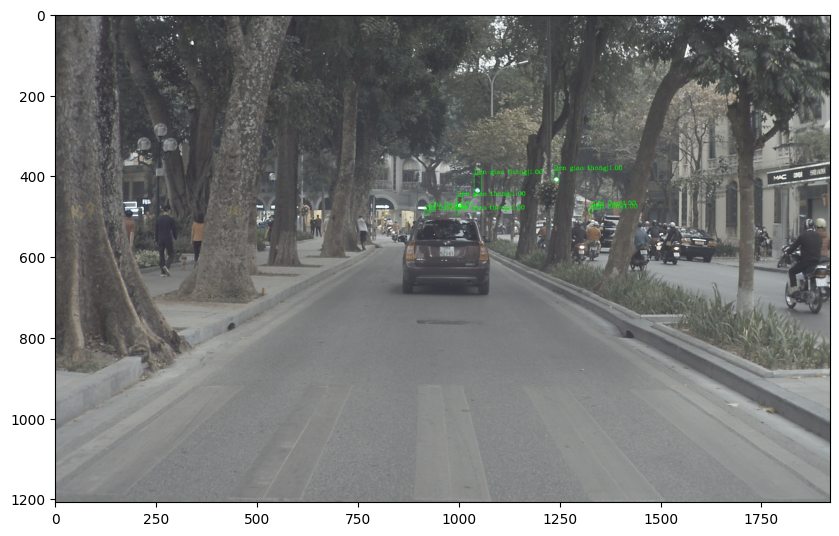

In [12]:
from avcv.visualize import show
img = vis.visualize(vis.img_ids[0])
show(img, dpi=100)

In [16]:
with open(out_dir+'/README.md', 'w') as f:
    f.write("""
    There are 6 superclasses you need to query. \n
    For each class, randomly select 20 images which containt the targeted class id.
    """)